In [16]:
# Run the dataInfo notebook to preprocess the data
%run dataInfo.ipynb

# Load the train and test datasets
train_df = train_df.dropna()  # Drop missing values in training data
test_df = test_df.dropna()  # Drop missing values in test data

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import itertools
 
# Define ranges for random_state values and additional hyperparameters
rf_random_states = [42, 82, 123, 200]
smote_random_states = [42, 452, 123, 300]
n_estimators = [50, 100, 200]
min_samples_leaf = [1, 2, 4]
 
# Create a parameter grid
param_grid = ParameterGrid({
    'rf_random_state': rf_random_states,
    'smote_random_state': smote_random_states,
    'n_estimators': n_estimators,
    'min_samples_leaf': min_samples_leaf
})
 
# Initialize variables to store the best parameters and scores
best_params = None
best_score = -float('inf')
 
# Iterate over all combinations of parameters
for params in param_grid:
    # Update parameters for SMOTE and RandomForestClassifier
    smote = SMOTE(random_state=params['smote_random_state'])
    rf_model = RandomForestClassifier(random_state=params['rf_random_state'], 
                                     class_weight='balanced',
                                     n_estimators=params['n_estimators'],
                                     min_samples_leaf=params['min_samples_leaf'])
 
    # Apply SMOTE to the training data
    X_resampled, y_resampled = smote.fit_resample(X, y)
 
    # Perform cross-validation
    scores = []
    for train_idx, val_idx in cv.split(X_resampled, y_resampled):
        X_train, X_val = X_resampled.iloc[train_idx], X_resampled.iloc[val_idx]
        y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]
 
        # Train the model
        rf_model.fit(X_train, y_train)
 
        # Make predictions
        y_val_pred = rf_model.predict(X_val)
        y_val_pred_proba = rf_model.predict_proba(X_val)[:, 1]
 
        # Calculate metrics (e.g., F1 score)
        f1 = f1_score(y_val, y_val_pred)
        scores.append(f1)
 
    # Calculate the mean score for this parameter combination
    mean_score = np.mean(scores)
 
    # Update the best parameters if the current score is better
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
 
print(f"Best Parameters: {best_params}")
print(f"Best F1 Score: {best_score}")

Best Parameters: {'min_samples_leaf': 1, 'n_estimators': 200, 'rf_random_state': 82, 'smote_random_state': 42}
Best F1 Score: 0.9195187818829581


In [20]:
# Train the Random Forest model using stratified 10-fold CV with 3 repeats

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, matthews_corrcoef
import numpy as np
import pandas as pd

# Preprocess the train dataset
X = train_df.drop(columns=['Class/ASD'])
y = train_df['Class/ASD']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Define the Random Forest model with the best parameters
rf_model = RandomForestClassifier(random_state=82, 
                                     class_weight='balanced', 
                                     n_estimators=200, 
                                     min_samples_leaf=1)

# Define stratified 10-fold CV with 3 repeats
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=12)

# Initialize lists to store metrics
roc_auc_scores = []
pr_auc_scores = []
f1_scores = []
mcc_scores = []

# Perform cross-validation
for train_idx, val_idx in cv.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled.iloc[train_idx], X_resampled.iloc[val_idx]
    y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_val_pred = rf_model.predict(X_val)
    y_val_pred_proba = rf_model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
    pr_auc = np.trapezoid(recall, precision)
    f1 = f1_score(y_val, y_val_pred)
    mcc = matthews_corrcoef(y_val, y_val_pred)

    # Append metrics to lists
    roc_auc_scores.append(roc_auc)
    pr_auc_scores.append(pr_auc)
    f1_scores.append(f1)
    mcc_scores.append(mcc)

# Calculate mean and confidence intervals for each metric
def calculate_ci(scores):
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    ci_lower = mean_score - 1.96 * std_score / np.sqrt(len(scores))
    ci_upper = mean_score + 1.96 * std_score / np.sqrt(len(scores))
    return mean_score, ci_lower, ci_upper

mean_roc_auc, ci_lower_roc_auc, ci_upper_roc_auc = calculate_ci(roc_auc_scores)
mean_pr_auc, ci_lower_pr_auc, ci_upper_pr_auc = calculate_ci(pr_auc_scores)
mean_f1, ci_lower_f1, ci_upper_f1 = calculate_ci(f1_scores)
mean_mcc, ci_lower_mcc, ci_upper_mcc = calculate_ci(mcc_scores)

# Print results
print(f"Mean ROC-AUC: {mean_roc_auc} (95% CI: {ci_lower_roc_auc}, {ci_upper_roc_auc})")
print(f"Mean PR-AUC: {mean_pr_auc} (95% CI: {ci_lower_pr_auc}, {ci_upper_pr_auc})")
print(f"Mean F1 Score: {mean_f1} (95% CI: {ci_lower_f1}, {ci_upper_f1})")
print(f"Mean Matthews Correlation Coefficient: {mean_mcc} (95% CI: {ci_lower_mcc}, {ci_upper_mcc})")

Mean ROC-AUC: 0.9669907407407407 (95% CI: 0.962317806968839, 0.9716636745126424)
Mean PR-AUC: 0.45858105967657914 (95% CI: 0.45182415022479444, 0.46533796912836384)
Mean F1 Score: 0.9195187818829581 (95% CI: 0.9111403340462849, 0.9278972297196313)
Mean Matthews Correlation Coefficient: 0.8359134900366888 (95% CI: 0.8182883790892742, 0.8535386009841034)


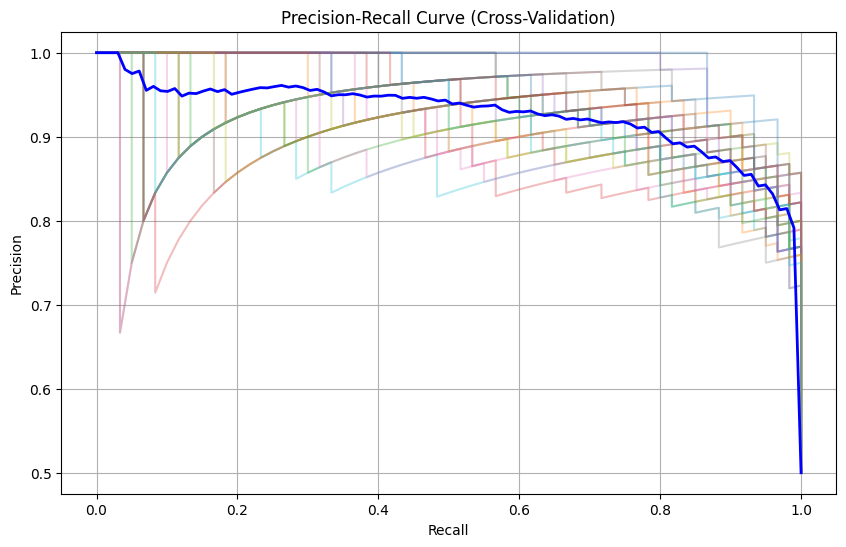

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))

# Initialize lists to store aggregated precision and recall
all_precision = []
all_recall = []

for train_idx, val_idx in cv.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled.iloc[train_idx], X_resampled.iloc[val_idx]
    y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_val_pred_proba = rf_model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)

    # Store precision and recall for aggregation
    all_precision.append(precision)
    all_recall.append(recall)

    # Plot the curve for this fold
    plt.plot(recall, precision, alpha=0.3, label='Fold PR Curve')

# Aggregate precision-recall curves
mean_precision = np.linspace(0, 1, 100)
mean_recall = np.zeros_like(mean_precision)

for precision, recall in zip(all_precision, all_recall):
    mean_recall += np.interp(mean_precision, np.flip(recall), np.flip(precision))
mean_recall /= len(all_precision)

# Calculate the area under the aggregated curve
pr_auc = auc(mean_precision, mean_recall)

# Plot the aggregated curve
plt.plot(mean_precision, mean_recall, color='blue', lw=2, label=f'Average PR Curve (AUC = {pr_auc:.2f})')

# Add labels and legend
plt.title('Precision-Recall Curve (Cross-Validation)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()